### Importing Necessary Modules

In [36]:
import pandas as pd
import numpy as np
import re
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy

from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score

import matplotlib.pyplot as plt

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Loading the Dataset

In [3]:
df = pd.read_csv("../data/kindle_reviews.csv")

In [3]:
df

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200
...,...,...,...,...,...,...,...,...,...,...
982614,982614,B00M13FNSS,"[2, 2]",5,Yasss hunny! This is a great read. That Dre is...,"07 23, 2014",A2Y66HD4J5S7QZ,Candi,A Hot Read Indeed!!,1406073600
982615,982615,B00M13FNSS,"[0, 0]",5,I ENJOYED THIS BOOK FROM BEGINNING TO END NOW ...,"07 23, 2014",A17YHECC8H9NEY,Margie,VERY GOOD BOOK,1406073600
982616,982616,B00M13FNSS,"[1, 1]",5,Great book! Cherika was a fool. She let that m...,"07 23, 2014",A20KO0BPMNREJL,Nicki,Great Read,1406073600
982617,982617,B00M13FNSS,"[0, 0]",5,When I say this was an excellent book please b...,"07 23, 2014",A1BQO66R6OLCCW,Nikey,Wow!!,1406073600


***Note***
- For this case, only review rating and review text will be used

In [5]:
to_use = df[["overall", "reviewText"]]

In [6]:
# Getting only 10% due to hardware constraints
large, small = train_test_split(to_use, test_size = 0.10, random_state = 42)

In [7]:
data = small

In [13]:
data.shape

(98262, 2)

### Text Preprocessing and Data Cleaning

In [14]:
# Checking for nan values
data.isnull().sum()

overall       0
reviewText    3
dtype: int64

In [8]:
# Since there are nan values in the reviewText, we will drop them
data = data.dropna()

In [16]:
data.isnull().sum()

overall       0
reviewText    0
dtype: int64

In [10]:
# Checking for duplicates
data.duplicated().sum()

2

In [9]:
# Removing duplicates
data = data.drop_duplicates()

In [19]:
data.duplicated().sum()

0

In [20]:
# Checking for class imbalances
data['overall'].value_counts()

overall
5    57740
4    25224
3     9562
2     3421
1     2310
Name: count, dtype: int64

In [10]:
# For review sentiment, 3 and greater is positive (1), 3 less is negative (0)

data['overall'] = data['overall'].map(lambda x: 0 if x < 3 else 1)

In [22]:
data['overall'].value_counts()

# Class imbalance needs to be addressed later on

overall
1    92526
0     5731
Name: count, dtype: int64

In [11]:
# Removing all special characters and lowering the string

data['reviewText'] = data['reviewText'].replace(regex = r"[^a-zA-Z0-9\s+]", value = '').str.lower()

In [12]:
#Using Spacy for speed

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def lemmatize(sentence: str) -> str:
    results = []
    for doc in nlp.pipe(sentence, batch_size=1000, n_process=6):  # 6 cores
        results.append(" ".join([t.lemma_ for t in doc if not t.is_stop]))
    return results

In [13]:
data['lemmatized_text'] = lemmatize(data['reviewText'])

In [14]:
# Removing any urls or any html tags
data['lemmatized_text'] = data['lemmatized_text'].apply(
    lambda x: re.sub(r"http\S+|www\S+|https\S+", "", x)
)

In [15]:
# Removing any html tags
data['lemmatized_text'] = data['lemmatized_text'].apply(
    lambda x: re.sub(r"<.*?>", "", x)
)

In [18]:
data

,overall,reviewText,lemmatized_text
869697,1,arc provided by author in exchange for an hone...,arc provide author exchange honest reviewthis ...
760913,1,wild ride by nancy warrenchanging gears series...,wild ride nancy warrenchange gear seriesduncan...
159841,1,well thought out story with many things going ...,think story thing go time alien race jump eart...
868915,1,this is book four of a five part serial by no...,book serial suspense high m like jess bo...
980703,1,i really enjoyed this book it kept me interest...,enjoy book keep interested page way end author...
...,...,...,...
767506,1,the second book in the series is very good so ...,second book series good good purchase read b...
385121,1,i love all of the sam moon books this was a su...,love sam moon book surprise medillion save son...
205925,1,not only was she kidnapped but she became a wi...,kidnap willing vessel want bad way revenge tur...
518557,1,if you have a gifted child you know first hand...,gifted child know hand exhausting lee binz exp...


In [21]:
# Saving cleaned data to CSV
data.to_csv("../artifacts/cleaned_data.csv")

In [16]:
corpus = data['lemmatized_text'].to_list()

In [17]:
# Convert into corpus

words = []

for sentence in corpus:
    words.append(word_tokenize(sentence))

### Train Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(words, data['overall'], test_size = 0.2, random_state = 42)

### Word2Vec

In [34]:
w2v = Word2Vec(sentences = X_train)

def avg_word2vec(sentence):
    vector = [w2v.wv[word] for word in sentence if word in w2v.wv.index_to_key]

    if vector:
        return np.mean(np.vstack(vector), axis = 0)
    
    else:
        return np.zeros(w2v.vector_size)

In [23]:
# Transforming the words into vectors
X_train_vec = np.array([avg_word2vec(token) for token in X_train])
X_test_vec = np.array([avg_word2vec(token) for token in X_test])

### Model Training

In [30]:
models = {
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "SVC": SVC(),
    "KNeighborsClassifier": KNeighborsClassifier()
}

train_metrics = {}

test_metrics = {}

In [26]:
def get_metrics(y_train, y_pred):
    acc = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)

    return acc, f1, recall

In [35]:
for name, model in models.items():
    print(f"Training model: {name}")
    
    model.fit(X_train_vec, y_train)

    #Testing for Train data
    y_pred_train = model.predict(X_train_vec)
    acc, f1, recall = get_metrics(y_train, y_pred_train)

    train_metrics[name] = [acc, f1, recall]

    #Testing for Test data
    y_pred_test = model.predict(X_test_vec)
    acc, f1, recall = get_metrics(y_test, y_pred_test)

    test_metrics[name] = [acc, f1, recall]

Training model: RandomForestClassifier
Training model: LogisticRegression
Training model: SVC
Training model: KNeighborsClassifier


In [ ]:
#Best model and results
max(list(test_metrics.items()), key = lambda x: x[1][0])

('SVC', [0.9466212090372481, 0.9724230395120798, 0.9982189119170984])

In [40]:
test_acc_scores = []

for i in test_metrics.values():
    test_acc_scores.append(i[0])

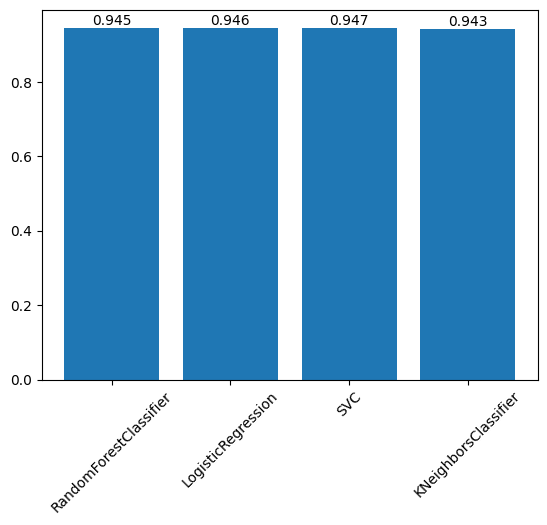

In [44]:
plt.bar(models.keys(), test_acc_scores)
for i, v in enumerate(test_acc_scores):
    plt.text(i, v, str(round(v, 3)), ha = 'center', va = 'bottom')
plt.xticks(rotation = 45)
plt.show()